In [151]:
# Listing 4-1 Importing stock price data using the Yahoo Finance package

import pandas_datareader as pdr
import datetime

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2019, 12, 31)

# Try FRED (Federal Reserve) or another API
# data = pdr.get_data_fred('SP500', start=start, end=end)  # S&P 500 as a test
# data = pdr.get_data_fred('DGS10', start=start, end=end)  # 10-Year Treasury Yield  as a test
# data = pdr.get_data_fred('CES0500000003', start=start, end=end)  # Hourly Earnings 
data = pdr.get_data_fred('DEXUSEU', start=start, end=end)  # Exchange Rates (USD to EUR)

print(data.head())



            DEXUSEU
DATE               
2019-01-01      NaN
2019-01-02   1.1357
2019-01-03   1.1399
2019-01-04   1.1410
2019-01-07   1.1468


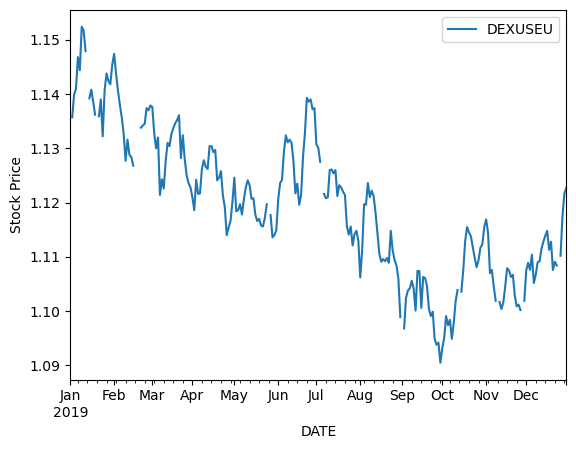

In [152]:
# “Listing 4-2 Plotting the stock price data”

import matplotlib.pyplot as plt
ax = data.plot()
ax.set_ylabel("Stock Price")
plt.show()

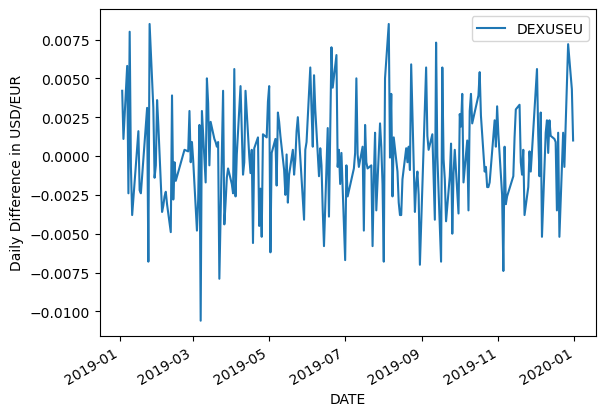

In [153]:
# “Listing 4-3 Computing the differenced data and plotting it”

# Need to difference
data = data.diff().dropna()
ax = data.plot()
# ax.set_ylabel("Daily Difference in Stock Price")
ax.set_ylabel("Daily Difference in USD/EUR")


plt.show()


In [154]:
# “Listing 4-4 Applying an ADF test to the differenced data”

from statsmodels.tsa.stattools import adfuller
result = adfuller(data)
pvalue = result[1]
# print(result)
if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')


stationary


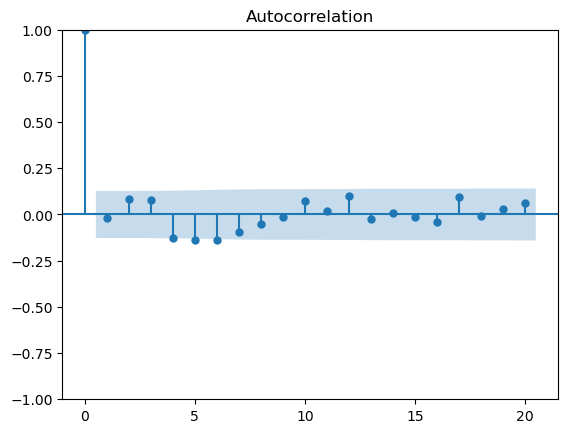

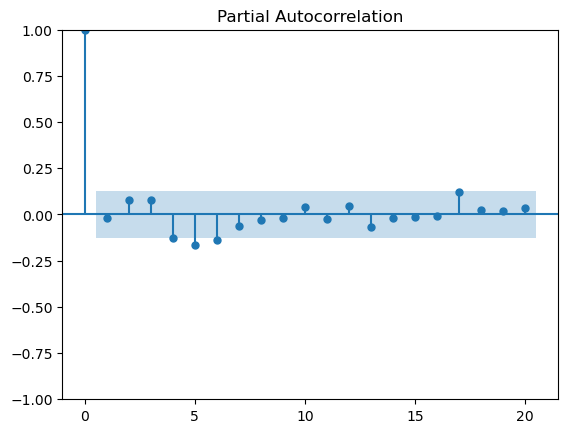

In [155]:
# “Listing 4-5 Plotting the autocorrelation”

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data, lags=20)
plot_pacf(data, lags=20)
plt.show()


/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


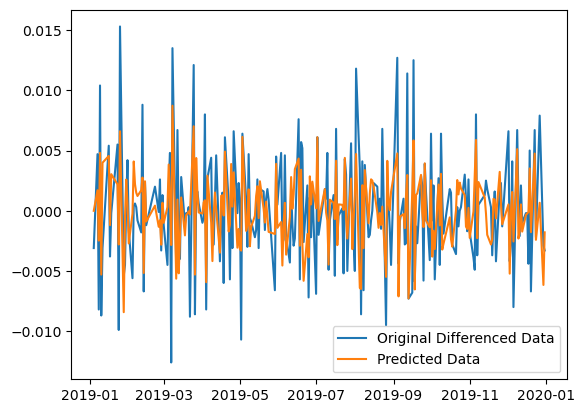

0.45100580825193004


In [156]:
# Listing 4-6 Fitting the MA model and plotting the forecast”

from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
# Forecast the first MA(1) model
mod = ARIMA(data.diff().dropna(), order=(0,0,3))
res = mod.fit()

orig_data = data.diff().dropna()
pred = res.predict()
plt.plot(orig_data, label="Original Differenced Data")
plt.plot(pred, label="Predicted Data")

plt.legend()  # Show legend to distinguish the plots

plt.show()
print(r2_score(orig_data, pred))


In [160]:
# “Listing 4-7 Fitting the MA model on train”
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

# Prepare train and test sets
diff_data = data.diff().dropna()

ld=len(diff_data)
train = diff_data[0:ld-10]
test = diff_data[ld-10:ld]

# Fit MA(1) model
mod = ARIMA(train, order=(0, 0, 1))
res = mod.fit()

# In-sample prediction
pred = res.predict(start=0, end=len(train)-1)

# Out-of-sample forecasting
fcst = res.forecast(steps=len(test))

# Evaluate R2 scores (using .values to avoid index issues)
print("Train R2 Score:", r2_score(train.values, pred.values))
print("Test R2 Score:", r2_score(test.values, fcst.values))

Train R2 Score: 0.4399627531663596
Test R2 Score: -4.819653625154352e-05


/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Pred

In [149]:
print("Train length:", len(train))
print("Model nobs:", res.nobs)
print("Test steps:", len(test))

Train length: 226
Model nobs: 226
Test steps: 10


In [162]:
len(diff_data)
len(fcst)

10

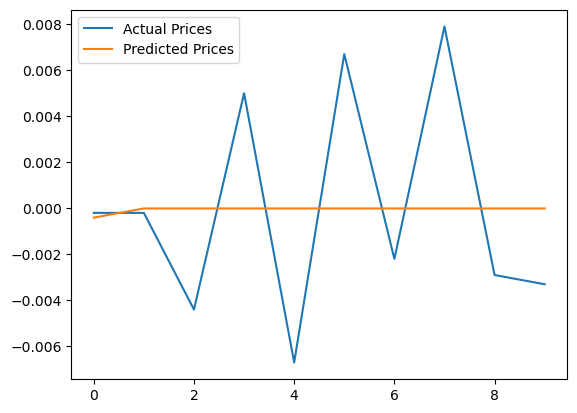

In [170]:
# Listing 4-8 Plotting the out-of-sample forecast of the MA(1) model (MA with order 1)


plt.plot(list(test.DEXUSEU))
plt.plot(list(fcst))
plt.legend(['Actual Prices', 'Predicted Prices'])
plt.show()


In [171]:
# Original Faulty Code
# Listing 4-9 Estimating the error of the MA(1) model for ten refitted one-step forecasts

import pandas as pd
ld=len(diff_data)
train = data.diff().dropna()[0:ld-10]
test = data.diff().dropna()[ld-10:ld]

train_list = list(train.DEXUSEU)
test_list = list(test.DEXUSEU)

# Import the ARMA module from statsmodels
from statsmodels.tsa.arima.model import ARIMA

fcst = []

for step in range(len(test)):
    # Forecast the first MA(1) model
    mod = ARIMA(train_list.reset_index(drop=True),order=(0,0,1))
    res = mod.fit()
    orig_data = data.diff().dropna()
    pred = res.predict()
    fcst += list(res.forecast(steps = 1))
    train = train_list.append(pd.Series(test_list[step]))

print(r2_score(list(test), fcst))
plt.plot(list(test))
plt.plot(fcst)
plt.legend(['Actual Prices', 'Predicted Prices'])
plt.show()

AttributeError: 'list' object has no attribute 'reset_index'

/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


R2 Score: 0.44253979015977785


/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


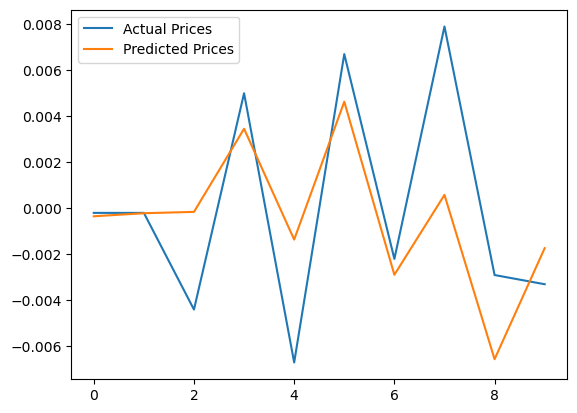

In [172]:
# Corrected code 
# Listing 4-9 Estimating the error of the MA(1) model for ten refitted one-step forecasts

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Assuming 'data' and 'diff_data' are already defined

# Preparing training and testing data
ld = len(diff_data)
train = data.diff().dropna()[0:ld-10]
test = data.diff().dropna()[ld-10:ld]

# Convert train and test data to lists
train_list = list(train.DEXUSEU)
test_list = list(test.DEXUSEU)

# Prepare forecast list
fcst = []

# Loop through test data and forecast
for step in range(len(test)):
    # Fit ARIMA model
    mod = ARIMA(train_list, order=(0, 0, 3))
    res = mod.fit()

    # Make a one-step forecast
    forecast_value = res.forecast(steps=1)
    fcst.append(forecast_value[0])  # Append the forecasted value

    # Update the train data by appending the new test value
    train_list.append(test_list[step])  # Efficient way to add test values for forecasting

# Calculate R2 score to evaluate forecast performance
print(f'R2 Score: {r2_score(test_list, fcst)}')

# Plot the actual vs predicted values
plt.plot(test_list, label='Actual Prices')
plt.plot(fcst, label='Predicted Prices')
plt.legend()
plt.show()


In [173]:
# “Listing 4-10 Grid search to obtain the MA order that optimizes forecasting R2”

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

def evaluate2(order):
    ld = len(diff_data)
    train = data.diff().dropna()[0:ld-10]
    test = data.diff().dropna()[ld-10:ld]

    # Convert train and test data to lists
    train_list = list(train.DEXUSEU)
    test_list = list(test.DEXUSEU)
       
    fcst = []

    for step in range(len(test_list)):
        # Fit ARIMA model
        mod = ARIMA(train_list, order=(0, 0, order))
        res = mod.fit()

        # Make a one-step forecast and append it
        fcst.append(res.forecast(steps=1)[0])  

        # Update the train list with the new observed value
        train_list.append(test_list[step])  

    # Compute and return R² score
    return r2_score(test_list, fcst)

# Perform grid search for MA order between 1 and 20
scores = [(i, evaluate2(i)) for i in range(1, 6)]

# Convert to DataFrame
scores_df = pd.DataFrame(scores, columns=['MA Order', 'R2 Score'])

# Print the best order
best_order = scores_df.loc[scores_df['R2 Score'].idxmax()]
print(f"Best Order: {best_order['MA Order']} with R²: {best_order['R2 Score']}")

# Print all scores
print(scores_df)


/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

Best Order: 3.0 with R²: 0.44253979015977785
   MA Order  R2 Score
0         1  0.421358
1         2  0.379469
2         3  0.442540
3         4  0.330642
4         5  0.386371


/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


R² Score: 0.4425


/Users/peerapoly/anaconda3/envs/tfmac_env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


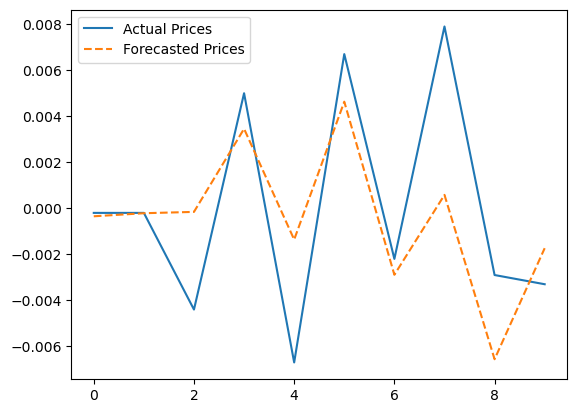

In [174]:
# “Listing 4-11 Obtaining the final forecast”

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score

# Train-test split
ld = len(diff_data)
train = data.diff().dropna()[0:ld-10]
test = data.diff().dropna()[ld-10:ld]

# Convert train and test data to lists
train_list = list(train.DEXUSEU)
test_list = list(test.DEXUSEU)

fcst = []

for step in range(len(test_list)):
    # Fit ARIMA model
    mod = ARIMA(train_list, order=(0, 0, 3))
    res = mod.fit()

    # Forecast one step ahead
    next_forecast = res.forecast(steps=1)[0]
    fcst.append(next_forecast)

    # Update train list with the observed value
    train_list += [test_list[step]]  

# Compute R² score outside the loop
r2 = r2_score(test_list, fcst)
print(f'R² Score: {r2:.4f}')

# Plot actual vs forecasted values
plt.plot(range(len(test_list)), test_list, label='Actual Prices')
plt.plot(range(len(fcst)), fcst, label='Forecasted Prices', linestyle='dashed')
plt.legend()
plt.show()
